In [3]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
# !pip install pip
# !pip install --upgrade pip
# !pip install scipy
import scipy as sp
import scipy.stats
import pandas as pd

# !pip install pystan
import stan
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# !pip install arviz
import arviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [ ]:
# !pip uninstall numba
# !pip install --upgrade numba

In [83]:
def diagnose(name):
    if 'disease' in name:
        return 1
    else:
        return 0

In [84]:
raw_df = pd.read_csv('./data/kidney_countdata.txt', sep='\t', quotechar='"')
raw_df.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

meta_df = pd.read_csv('./data/kidney_metadata.txt', sep='\t', quotechar='"')
meta_df.rename(columns={'Unnamed: 0': 'ROI'}, inplace=True)
meta_df['diagnosis'] = meta_df['slide name'].map(diagnose)

276


1    159
0    117
Name: diagnosis, dtype: int64
disease3     59
normal3      59
disease1B    39
disease2B    37
normal2B     35
disease4     24
normal4      23
Name: slide name, dtype: int64


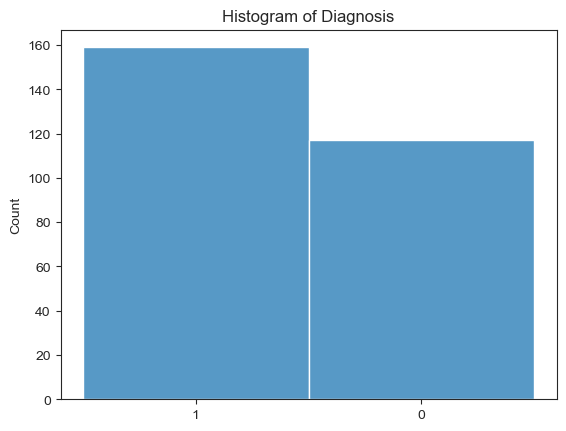

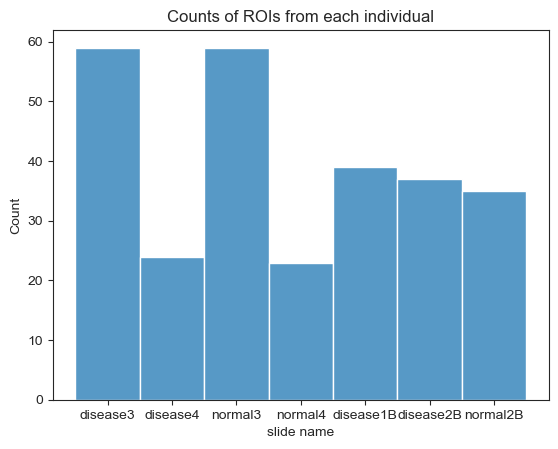

In [85]:
print(meta_df['diagnosis'].value_counts())
print(meta_df['slide name'].value_counts())
sns.histplot([str(x) for x in meta_df['diagnosis'].values])
plt.title('Histogram of Diagnosis')
plt.show()

sns.histplot(meta_df['slide name'])
plt.title('Counts of ROIs from each individual')
plt.show()

In [79]:
test_ROIs = meta_df[(meta_df['slide name'] == 'disease4') | (meta_df['slide name'] == 'normal4')]['ROI'].values
# print(meta_df.head())
print(test_ROIs)

['DSP-1001250007851-H-E01.dcc' 'DSP-1001250007851-H-E02.dcc'
 'DSP-1001250007851-H-E03.dcc' 'DSP-1001250007851-H-E04.dcc'
 'DSP-1001250007851-H-E05.dcc' 'DSP-1001250007851-H-E06.dcc'
 'DSP-1001250007851-H-E07.dcc' 'DSP-1001250007851-H-E08.dcc'
 'DSP-1001250007851-H-E09.dcc' 'DSP-1001250007851-H-E10.dcc'
 'DSP-1001250007851-H-E11.dcc' 'DSP-1001250007851-H-E12.dcc'
 'DSP-1001250007851-H-F01.dcc' 'DSP-1001250007851-H-F02.dcc'
 'DSP-1001250007851-H-F03.dcc' 'DSP-1001250007851-H-F04.dcc'
 'DSP-1001250007851-H-F05.dcc' 'DSP-1001250007851-H-F06.dcc'
 'DSP-1001250007851-H-F07.dcc' 'DSP-1001250007851-H-F08.dcc'
 'DSP-1001250007851-H-F09.dcc' 'DSP-1001250007851-H-F10.dcc'
 'DSP-1001250007851-H-F11.dcc' 'DSP-1001250007851-H-F12.dcc'
 'DSP-1001250007864-D-F02.dcc' 'DSP-1001250007864-D-F03.dcc'
 'DSP-1001250007864-D-F04.dcc' 'DSP-1001250007864-D-F05.dcc'
 'DSP-1001250007864-D-F06.dcc' 'DSP-1001250007864-D-F07.dcc'
 'DSP-1001250007864-D-F08.dcc' 'DSP-1001250007864-D-F09.dcc'
 'DSP-1001250007864-D-F1

We develop a multinomial model where the health status (Normal or Diseased) associated with a sample $m$ is the dependent variable $Y_m\in\{0,1\}$ and the independent variable $X^m$ is the gene expression of the sample. We will model a score $Z=\beta\cdot X$, which can be converted into a probability of $Y_m$ given $(X^m,\beta)$. In our initial implementation, we model the $\beta$ values as being drawn from a normal distribution. Our model is therefore:
$$Y\in\{0, 1\}$$
$$Y^i\sim\text{Bernoulli}\left(\rho_i\right)$$
$$Z_i=\sum_j x_j^iB_j$$
$$P\left(Y_i\right)=\text{logit}\left(Z_i\right)$$
$$B_j\sim N\left(0,\sigma\right)$$
$$\sigma=1$$

In [86]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_code = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [108]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_laplace = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ double_exponential(0, 1);
    beta ~ double_exponential(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [116]:
# df = raw_df.head(10)
df = raw_df
threshold = 1
column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col not in test_ROIs]
test_column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col in test_ROIs]
print(len(column_list))

# # Option 1: normalize by sum of all counts for an ROI, multiplied by 1,000 to prevent underflow
# X = np.array([df[col]*10/sum(df[col]) for col in column_list])
# print(len(X))

# Option 2: normalize using z-score method:
X = [sp.stats.zscore(df[col]).tolist() for col in column_list]
test_X = [sp.stats.zscore(df[col]).tolist() for col in test_column_list]

Y = []
for col in column_list:
    Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

test_Y = []
for col in test_column_list:
    test_Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

# print(Y)
print(len(Y))

# print(X)
print(len(X))
print(len(X[0]))

229
229
229
18642


In [97]:
import math
math.comb(229, 1)

229

In [88]:
import json
data = {'N': len(X), 'q': len(df), 'X': X, 'Y': Y}

with open("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/genes/model_norm/model_norm.data.json", "w") as f:
    json.dump(data, f)

In [109]:
model = stan.build(model_laplace, data={'N': len(X), 'q': len(df), 'X': X, 'Y': Y})

Building...

In file included from /Users/ethanratliff-crain/Library/Caches/httpstan/4.10.1/models/b5fqgrf5/model_b5fqgrf5.cpp:2:
In file included from /Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
In file included from /Users/ethanratliff-crain/Library/Caches/httpstan/4.

13 warnings generated.
ld: warning: object file (/Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/ethanratliff-crain/opt/anaconda3/lib/python3.9/site-packages/httpstan/stan_services.o' to global we

In [ ]:
fit = model.sample(num_chains=4, num_samples=1000)

In [ ]:
fit_az = arviz.from_pystan(fit)
arviz.summary(fit_az)

In [136]:
t_out = pd.read_csv("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output.csv",
                    comment='#')
print(t_out.head())
print(len(t_out))
t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]
print(max(t_betas))
abs_betas = np.abs(t_betas)
np_betas = np.array(t_betas)
genes_to_use = df[abs_betas > 0.01]['gene']
t_betas_to_use = np_betas[abs_betas > 0.01]


      lp__         alpha   beta.1    beta.2        beta.3        beta.4  \
0 -123.246  5.133490e-08 -1.11657 -0.000001 -9.676970e-07  7.712180e-07   

     beta.5        beta.6        beta.7        beta.8  ...    z.220    z.221  \
0 -0.000002 -3.256140e-07 -2.936810e-07 -7.280630e-07  ...  148.578  121.116   

     z.222    z.223    z.224    z.225    z.226    z.227    z.228    z.229  
0  150.552  162.241  116.849  65.3392  167.449  130.193  409.749  354.574  

[1 rows x 18873 columns]
1
8.33252


In [ ]:
# p_betas = [np.mean(x) for x in fit['beta']]
# sns.histplot(p_betas, label='sampled')
sns.histplot(t_betas, label='optimized')
plt.show()

sns.histplot(np.abs(t_betas), label='optimized')

In [ ]:
az.plot_trace(fit_simple_az, var_names=['alpha', 'beta', 'sigma']);
plt.tight_layout()

In [ ]:
# any diverging transitions?
print("Number of diverging samples: {}".format(fit['divergent__'].sum()))

In [ ]:
print(len(fit['beta']))

In [ ]:
# posterior of z
plt.figure(figsize=(4, 4))
sns.kdeplot(fit['beta'][:])
plt.xlabel(r"$\beta$")
plt.ylabel("Posterior density")
sns.despine()
plt.legend()

In [ ]:
# viz_scatter()
from sklearn.metrics import confusion_matrix
import random

correct_guesses = 0
total_guesses = 0
# add simulated data points
for i in range(10):
    idx = np.random.randint(0, 4000)
    scaled = [fit['beta'][:, idx] * x[:] for x in X]
    z = [fit['alpha'][0, idx] + sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
#     r = [random.random() for _ in range(len(Y_tilde))]
#     correct_guesses += len(r[r < Y_tilde])
#     total_guesses += len(r)

# print(correct_guesses / total_guesses)

plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# sns.despine()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.0

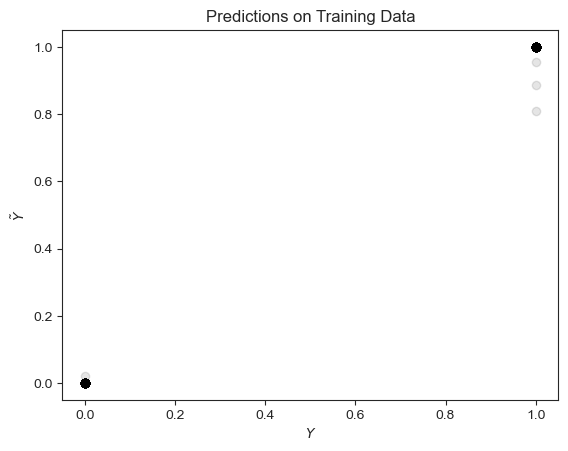

In [137]:
correct_guesses = 0
total_guesses = 0
# add simulated data points

scaled = [np.array(t_betas) * x[:] for x in X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()

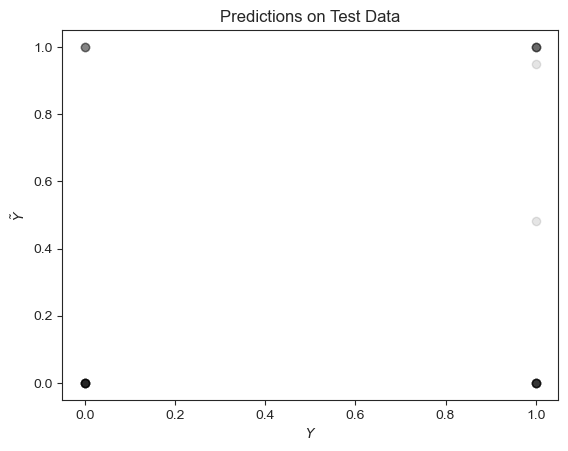

                            ROI  Y           P(Y)  accuracy  samples
0   DSP-1001250007851-H-E01.dcc  1  2.216623e-117         0        1
1   DSP-1001250007851-H-E02.dcc  1   5.265996e-55         0        1
2   DSP-1001250007851-H-E03.dcc  1  3.772404e-161         0        1
3   DSP-1001250007851-H-E04.dcc  1  3.019586e-178         0        1
4   DSP-1001250007851-H-E05.dcc  1   5.068687e-52         0        1
5   DSP-1001250007851-H-E06.dcc  1   4.809954e-01         0        1
6   DSP-1001250007851-H-E07.dcc  1   1.726684e-93         0        1
7   DSP-1001250007851-H-E08.dcc  1   1.000000e+00         1        1
8   DSP-1001250007851-H-E09.dcc  1   5.523687e-25         0        1
9   DSP-1001250007851-H-E10.dcc  1   1.000000e+00         1        1
10  DSP-1001250007851-H-E11.dcc  1   2.849681e-08         0        1
11  DSP-1001250007851-H-E12.dcc  1   1.000000e+00         1        1
12  DSP-1001250007851-H-F01.dcc  1   1.000000e+00         1        1
13  DSP-1001250007851-H-F02.dcc  1

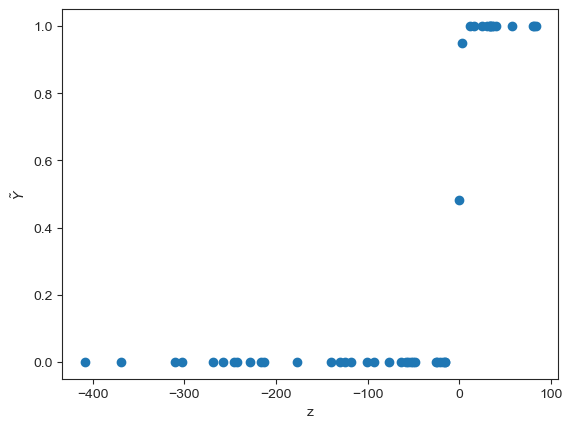

In [138]:
correct_guesses = 0
total_guesses = 0
# add simulated data points

scaled = [np.array(t_betas) * x[:] for x in test_X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Test Data')
plt.show()

z.sort()
plt.scatter(z, np.exp(z) / (1 + np.exp(z)))
plt.xlabel('z')
plt.ylabel(r'$\tilde{Y}$')

accuracy = []
for i in range(len(Y_tilde)):
    if Y_tilde[i] > 0.5:
        accuracy.append(1 if test_Y[i] == 1 else 0)
    else:
        accuracy.append(1 if test_Y[i] == 0 else 0)
summary_table = pd.DataFrame({'ROI': test_column_list, 'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
print(summary_table)
s_g = summary_table.groupby('Y').sum()
print(s_g)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[9.99377184e-01 9.99182726e-01 9.99867615e-01 9.99601508e-01
 9.99904162e-01 9.99958654e-01 9.99976078e-01 9.97208565e-01
 9.98650674e-01 9.99837305e-01 9.99297929e-01 9.99703206e-01
 9.99799478e-01 9.99427610e-01 9.99655428e-01 9.99820912e-01
 9.99875871e-01 9.99556030e-01 9.99696168e-01 9.99886405e-01
 9.9955

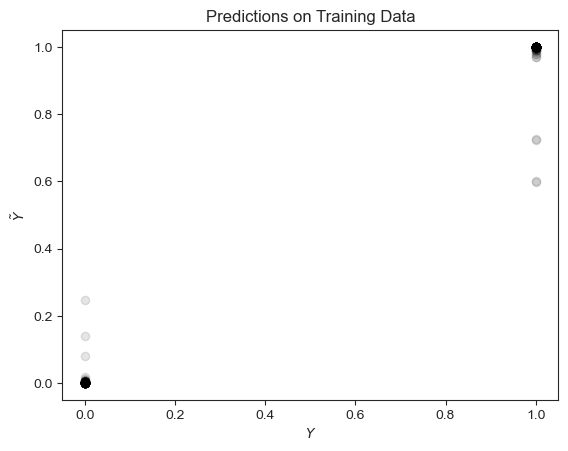

In [57]:
X_to_use = np.array(X)
X_to_use = [x[abs_betas > 0.01] for x in X_to_use]
test_X_to_use = np.array(test_X)
test_X_to_use = [x[abs_betas > 0.01] for x in test_X_to_use]
scaled = [np.array(t_betas_to_use) * x[:] for x in X_to_use]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()

47
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3.11468841e-03 1.78283666e-02 1.07966797e-05 1.40800453e-05
 3.32997015e-01 3.70496443e-01 1.56215198e-03 8.06891807e-01
 8.86481933e-01 9.69249861e-01 9.11359016e-01 8.74739593e-01
 2.14252032e-01 4.33836078e-02 4.01979035e-01 1.33147728e-01
 6.60343761e-02 3.16677562e-03 2.01098191e-03 1.62542593e-05
 2.0

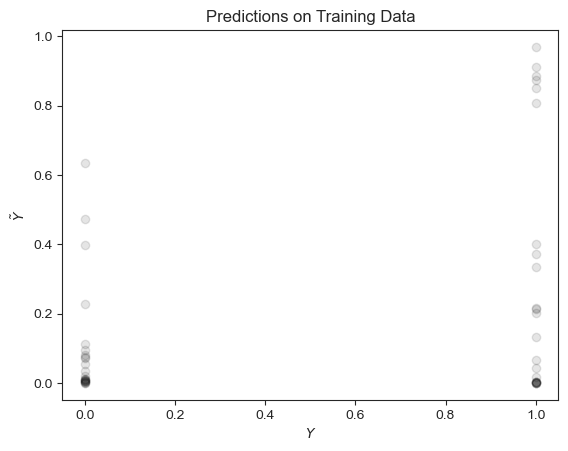

In [66]:
print(len(test_X))
test_X_to_use = np.array(test_X)
test_X_to_use = [x[abs_betas > 0.01] for x in test_X_to_use]
scaled = [np.array(t_betas_to_use) * x[:] for x in test_X_to_use]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()